# GTI770 -- Laboratoire 1

**Par : Équipe 18 **  
    Michel-Olivier Bouchard  
    Francis Cadorette  
    Mathieu Poulin  

### CODE

In [2]:
# Imports General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import matplotlib

In [3]:
# Imports Skimage
from skimage import data, io, filters, feature, color
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon

In [4]:
# Imports Scikit-Learn
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [5]:
#Imports from TP1 GTI770-H2018
import csv
import math
import scipy.ndimage as nd
from scipy.stats.mstats import mquantiles, kurtosis, skew
from sklearn.preprocessing import LabelEncoder

In [6]:
import cv2

In [7]:
csvFile = open("GTI770_label_data_set.csv", "r")
CONST_NB_TRAIN = 70 #10140
CONST_NB_VALIDATE = 20 #3350
CONST_NB_TEST = 10 #3350
CONST_NB_TOTAL = CONST_NB_TRAIN + CONST_NB_VALIDATE + CONST_NB_TEST
countTotal = 0
countSmooth = 0
countSpiral = 0
X = np.zeros((CONST_NB_TOTAL, 3, 424, 424),dtype=int) # matrice X de la forme (nombre d'image, nombre de canaux(RGB), hauteur, largeur)
Y = np.zeros((CONST_NB_TOTAL, 1), 'U6')     # matrice Y de la forme (nombre d'image, la classe)
for i in csvFile:
    imageId, imageClass = i.split(',')
    imageClass = imageClass[0:6]
    if imageId != "id":
        if imageClass == "smooth" : # si la classe de l'image est 'smooth'
            if countSmooth == CONST_NB_TOTAL//2 :  # s'il y a CONST_NB_TOTAL/2 image de cette classe
                continue            # passe a la prochaine image
            countSmooth += 1
        elif imageClass == "spiral" :
            if countSpiral == CONST_NB_TOTAL//2 :
                continue
            countSpiral += 1
        else :
            continue
        imagePath = 'images_training/' + imageId + '.jpg'
        if not os.path.exists(imagePath):
            continue
        img = cv2.imread(imagePath)
        img = img.reshape(3, 424, 424)
        X[countTotal] = img        # ajouter l'image dans la matrice X
        Y[countTotal] = imageClass # ajouter sa classe dans la matrice Y
        countTotal += 1
        if countTotal == CONST_NB_TOTAL: # arrete a CONST_NB_TOTAL images totales (CONST_NB_TOTAL/2 de chaque classe)
            break

In [8]:
X_train = np.zeros((CONST_NB_TRAIN, 3, 424, 424),dtype=int) # matrice X_train avec CONST_NB_TRAIN/2 de chaque classe
X_validate = np.zeros((CONST_NB_VALIDATE, 3, 424, 424),dtype=int) # matrice X_validate avec CONST_NB_VALIDATE/2 de chaque classe
X_test = np.zeros((CONST_NB_TEST, 3, 424, 424),dtype=int)  # matrice X_test avec CONST_NB_TEST/2 de chaque classe
Y_train = np.zeros((CONST_NB_TRAIN, 1), 'U6')     # matrice Y_train avec CONST_NB_TRAIN/2 de chaque classe
Y_validate = np.zeros((CONST_NB_VALIDATE, 1), 'U6')     # matrice Y_train avec CONST_NB_VALIDATE/2 de chaque classe
Y_test = np.zeros((CONST_NB_TEST, 1), 'U6')      # matrice Y_test avec CONST_NB_TEST/2 de chaque classe
#countTotal = 0
countX = 0
countValidate = 0
countTest = 0
countTrainSmooth = 0
countTrainSpiral = 0
countValidateSmooth = 0
countValidateSpiral = 0
for j in X : 
    countTotal += 1
    imageClass = Y[countX][0]
    if imageClass == "smooth" :
        if countTrainSmooth == CONST_NB_TRAIN//2 :   # une fois que CONST_NB_TRAIN/2 des smooth sont dans X_train
            if countValidateSmooth == CONST_NB_VALIDATE//2 :
                #print("add ", countTotal," to smooth test", countTest)
                X_test[countTest] = X[countX]  # ajout de l'image dans X_test
                Y_test[countTest] = Y[countX]  # ajout de la classe dans Y_test
                countTest += 1                 # incremente l'index de X_test
                countX += 1                    # incremente l'index global
                continue
            #print("add ", countTotal," to smooth validate", countValidate)
            X_validate[countValidate - countTest] = X[countX]  # ajout de l'image dans X_validate
            Y_validate[countValidate - countTest] = Y[countX]  # ajout de la classe dans Y_validate
            countValidate += 1        # incremente l'index de X_validate
            countValidateSmooth += 1  # incremente le nb de smooth dans X_validate pour verifier la condition
            countX += 1               # incremente l'index global
            continue
        #print("add ", countTotal," to smooth train", countX)
        X_train[countX - (countValidate + countTest)] = X[countX]   # ajout de l'image dans X_train
        Y_train[countX - (countValidate + countTest)] = Y[countX]   # ajout de la classe dans Y_train
        countTrainSmooth += 1         # incremente le nb de smooth dans X_train pour verifier la condition
        countX += 1
    elif imageClass == "spiral" :
        if countTrainSpiral == CONST_NB_TRAIN//2 :
            if countValidateSpiral == CONST_NB_VALIDATE//2 :
                #print("add ", countTotal," to spiral test", countTest)
                X_test[countTest] = X[countX]
                Y_test[countTest] = Y[countX]
                countTest += 1
                countX += 1
                continue
            #print("add ", countTotal," to spiral validate", countValidate)
            X_validate[countValidate - countTest] = X[countX]
            Y_validate[countValidate - countTest] = Y[countX]
            countValidate += 1
            countValidateSpiral += 1
            countX += 1
            continue
        #print("add ", countTotal," to spiral train", countX)
        X_train[countX - (countValidate + countTest)] = X[countX]   # ajout de l'image dans X_train
        Y_train[countX - (countValidate + countTest)] = Y[countX]   # ajout de la classe dans Y_train
        countTrainSpiral += 1
        countX += 1
    else :
        continue

In [9]:
X_train_crop = np.zeros((CONST_NB_TRAIN, 3, 150, 150),dtype=int) # matrice X_train avec 35 de chaque classe
X_validate_crop = np.zeros((CONST_NB_VALIDATE, 3, 150, 150),dtype=int) # matrice X_train avec 35 de chaque classe
X_test_crop = np.zeros((CONST_NB_TEST, 3, 150, 150),dtype=int)  # matrice X_test avec 15 de chaque classe

countCrop = 0
#X_train
for xtrain in X_train :
    image = X_train[countCrop].reshape(424, 424, 3)
    image = image[424 // 2 - 150 // 2: 424 // 2 + 150 // 2, 424 // 2 - 150 // 2: 424 // 2 + 150 // 2] # garder 75 de chaque cote depuis le milieu, pour chaque axe
    image = image.reshape(3, 150, 150)
    X_train_crop[countCrop] = image
    countCrop += 1

countCrop = 0
#X_validate
for xvalidate in X_validate :
    image = X_validate[countCrop].reshape(424, 424, 3)
    image = image[424 // 2 - 150 // 2: 424 // 2 + 150 // 2, 424 // 2 - 150 // 2: 424 // 2 + 150 // 2] # garder 75 de chaque cote depuis le milieu, pour chaque axe
    image = image.reshape(3, 150, 150)
    X_validate_crop[countCrop] = image
    countCrop += 1
    
countCrop = 0
#X_test
for xtest in X_test :
    image = X_test[countCrop].reshape(424, 424, 3)
    image = image[424 // 2 - 150 // 2: 424 // 2 + 150 // 2, 424 // 2 - 150 // 2: 424 // 2 + 150 // 2]
    image = image.reshape(3, 150, 150)
    X_test_crop[countCrop] = image
    countCrop += 1

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['spiral']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

['smooth']


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

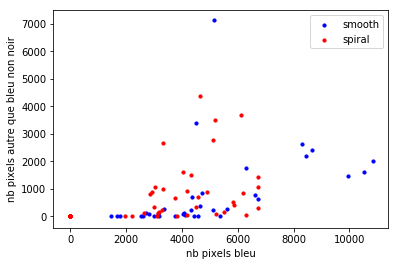

In [11]:
#PRIMITIVE DE COULEURS
#La primitive utilisée est le nombre de pixels bleus
X_train_binary = np.zeros((CONST_NB_TRAIN, 150, 150),dtype=int)
X_train_color_plot = np.zeros((CONST_NB_TRAIN, 2, 3))  # CONST_NB_TRAIN images, 0 smooth et 1 spiral, 0 nb pixels range de bleu et 1 nb pixels autres non noir
countPriColor = 0
for xtrain in X_train_crop :
    image = X_train_crop[countPriColor].reshape(150, 150, 3)
    imageGray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
    imageGray = imageGray.reshape(1,150,150)
    
    for i in range(0,149):   # passe au travers de chaque pixel
        for j in range(0,149):
            if imageGray[0][i][j]<50:  # si le treshold est inferieur a 50, on le considere comme noir
                X_train_binary[countPriColor][i][j] = 0
               
            else :                     # sinon, on le considere comme blanc
                X_train_binary[countPriColor][i][j] = 1
                
    
    #img_color_cloned = image.copy() #utile pour voir l'analyse des couleurs
    
    if Y_train[countPriColor][0] == "smooth" :
        for i in range(0,149):   # passe au travers de chaque pixel
            for j in range(0,149):
                red = image[i][j][2]
                gre = image[i][j][1]
                blu = image[i][j][0]
                
                if blu >= 100 :#(blu >= 200 and gre >= 200 and red >= 200) or (blu >= (gre + 70) and blu >= (red + 70)):#blu >= 100 and blu <= 255 and gre >= 0 and gre <=200 and red >= 0 and red <= 200:
                    X_train_color_plot[countPriColor][0][0] += 1
                    #img_color_cloned[i][j] = [0,255,0] #utile pour voir l'analyse des couleurs
                elif imageGray[0][i][j]>50:
                    X_train_color_plot[countPriColor][0][1] += 1
                    #img_color_cloned[i][j] = [255,0,0] #utile pour voir l'analyse des couleurs
        #le ratio de pixels bleus sur les pixels d'autre couleurs
        X_train_color_plot[countPriColor][0][2] = X_train_color_plot[countPriColor][0][0]/X_train_color_plot[countPriColor][0][1]
        X_train_primitives[countPriColor][0] = X_train_color_plot[countPriColor][0][0]
    
    else :
        for i in range(0,149):   # passe au travers de chaque pixel
            for j in range(0,149):
                red = image[i][j][2]
                gre = image[i][j][1]
                blu = image[i][j][0]
                
                if blu >= 100 :#(blu >= 200 and gre >= 200 and red >= 200) or (blu >= (gre + 70) and blu >= (red + 70)):#blu >= 100 and blu <= 255:# and gre >= 0 and gre <=200 and red >= 0 and red <= 200:
                    X_train_color_plot[countPriColor][1][0] += 1
                    #img_color_cloned[i][j] = [0,255,0]  #utile pour voir l'analyse des couleurs
                elif imageGray[0][i][j]>50:
                    X_train_color_plot[countPriColor][1][1] += 1
                    #img_color_cloned[i][j] = [255,0,0]  #utile pour voir l'analyse des couleurs
        #le ratio de pixels bleus sur les pixels d'autre couleurs
        X_train_color_plot[countPriColor][1][2] = X_train_color_plot[countPriColor][1][0]/X_train_color_plot[countPriColor][1][1]
        X_train_primitives[countPriColor][0] = X_train_color_plot[countPriColor][1][0]
    
    #utile pour voir l'analyse des couleurs
    #print(Y_train[countPriColor])
    #plt.imshow(image)
    #plt.show()
    #plt.imshow(img_color_cloned)
    #plt.show()
    
    
    countPriColor += 1
    
    
# afficher graphe primitives
cm = plt.cm.RdBu

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train_color_plot[:,0,0], X_train_color_plot[:,0,1], s=10, c='b', label='smooth')
ax1.scatter(X_train_color_plot[:,1,0], X_train_color_plot[:,1,1], s=10, c='r', label='spiral')
plt.legend(loc='upper right');
plt.xlabel('nb pixels bleu')
plt.ylabel('nb pixels autre que bleu non noir')
#plt.ylabel('ratio bleu sur autres')
plt.show()


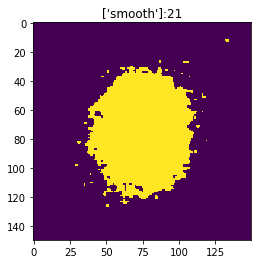

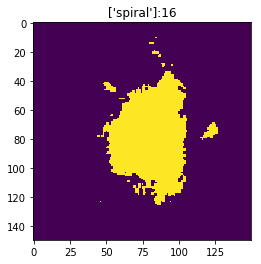

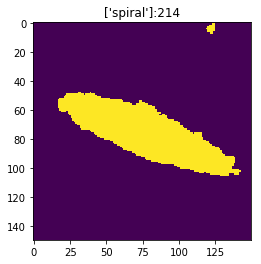

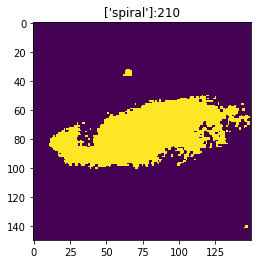

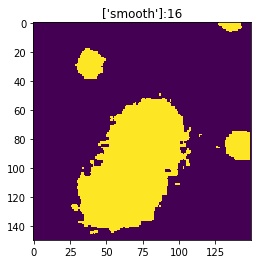

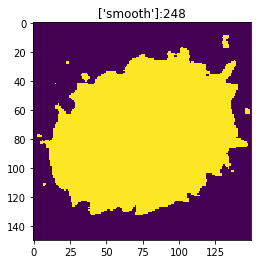

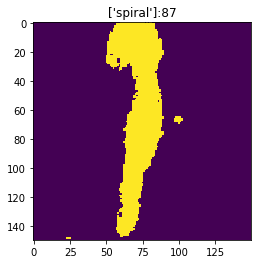

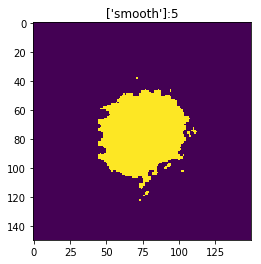

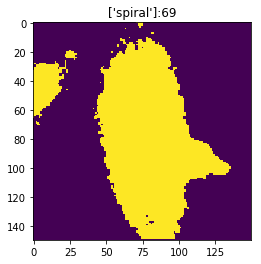

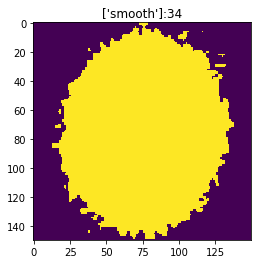

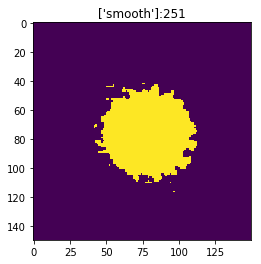

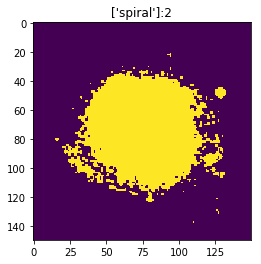

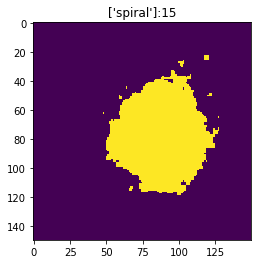

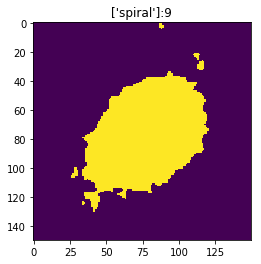

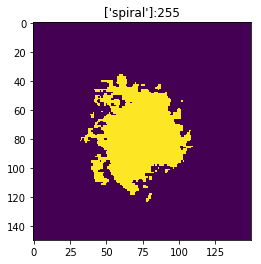

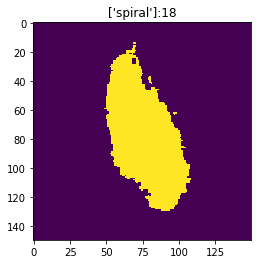

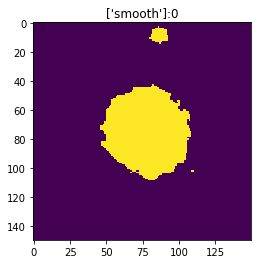

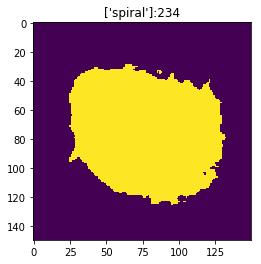

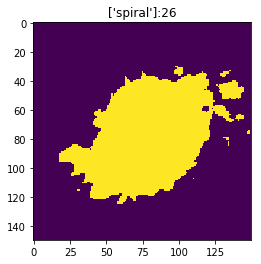

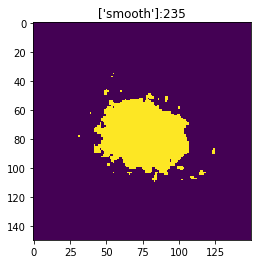

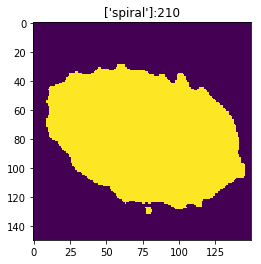

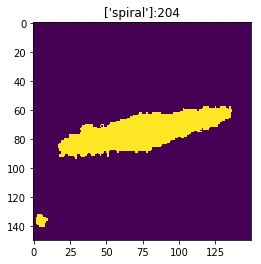

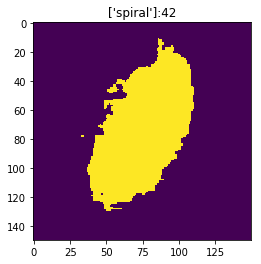

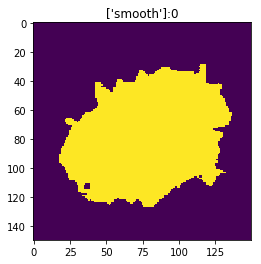

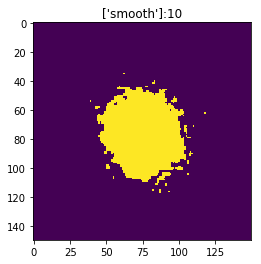

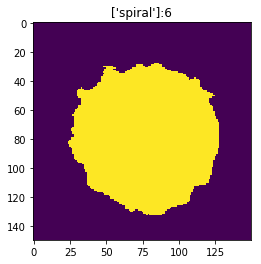

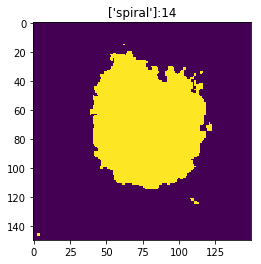

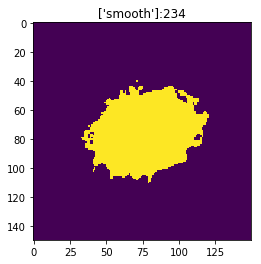

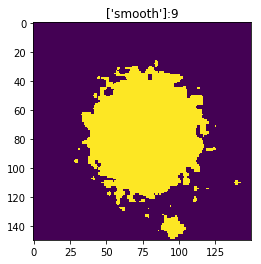

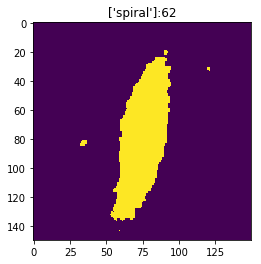

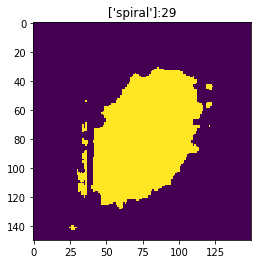

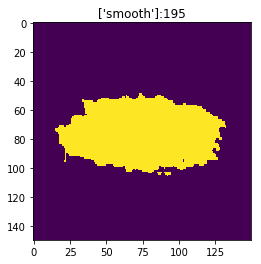

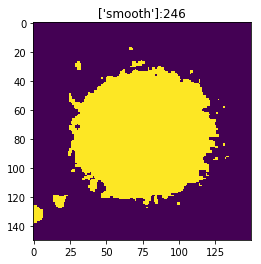

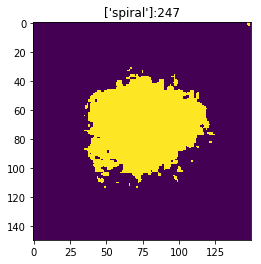

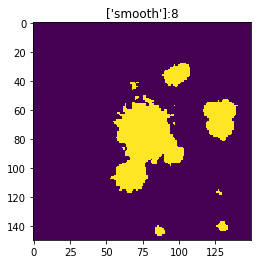

KeyboardInterrupt: 

In [12]:
#ici, nous allons faire l'évaluation d'un score selon l'allongement possible de la forme.
#Ce score tiendra le compte de point lumineux dans l'image binaire de nos galaxy dans 6 directions :
#bas, haut, gauche, droite et 2 diagonales. Si la forme présente un certain allongment, le score devrait être plus élever, 
#ainsi, peu de smooth devrait avoir un score élever et nous nous attendons à avoir un quantité de spirale plus élever dans
#formes allongées

countBinary = 0
scores = np.zeros(CONST_NB_TRAIN, dtype="uint8")
score = 0

images_a_visualiser = np.zeros((CONST_NB_TRAIN, 150, 150))
for xtrain in X_train_crop :
   
    centre_y = 75
    centre_x = 75
    score = 0
    
    decal_diag_droite = centre_x
    decal_diag_gauche = centre_x
    
    decal = 1
    for j in range(0,75) :
        
        #droite
        if X_train_binary[countBinary][centre_y][centre_y + decal] >= 1 :
            score-=1
        
        #gauche
        if X_train_binary[countBinary][centre_y][centre_y - decal] >= 1 :
            score-=1
        
        #diagonale droite
        decal_diag_droite+=1
        if X_train_binary[countBinary][centre_y - decal][decal_diag_droite] >= 1 :
            score+=1
        
        #diagonale gauche
        decal_diag_gauche-=1
        if X_train_binary[countBinary][centre_y-decal][decal_diag_gauche] >= 1 :
            score-=1
        
        #bas
        if X_train_binary[countBinary][centre_y+decal][centre_x] >= 1 :
            score+=1
            
        #haut
        if X_train_binary[countBinary][centre_y-decal][centre_x] >= 1 :
            score+=1    
        
    
        decal+=1
        if decal == 74 : 
            break

    #print(score)
    scores[countBinary] = score
    images_a_visualiser[countBinary] = X_train_binary[countBinary]
    countBinary+=1
    
#Visualisation de la procedure d'extraction
countBinary = 0
countSmooth = 0
countSpiral = 0
for i in images_a_visualiser : 
    image = images_a_visualiser[countBinary]
    plt.imshow(image/255)
    plt.title(""+str(Y_train[countBinary])+":"+str(scores[countBinary]))
    plt.show()
    if Y_train[countBinary][0] == "smooth" :
        X_train_color_plot[countSmooth][0][2] = scores[countBinary]
        X_train_color_plot[countSmooth][0][4] = countBinary
        countSmooth+=1
    else :
        X_train_color_plot[countSpiral][1][2] = scores[countBinary]
        X_train_color_plot[countSpiral][1][4] = countBinary
        countSpiral+=1
    countBinary+=1
    if(countBinary) >= images_a_visualiser.shape[0] :
        break
        
# afficher graphe primitives
cm = plt.cm.RdBu

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train_color_plot[:,0,2], X_train_color_plot[:,0,4] , s=10, c='b', label='smooth')
ax1.scatter(X_train_color_plot[:,1,2], X_train_color_plot[:,1,4], s=10, c='r', label='spiral')
plt.legend(loc='upper right');
plt.xlabel('alongement de la forme')
plt.ylabel('# galaxie')
plt.show()
        

len 70


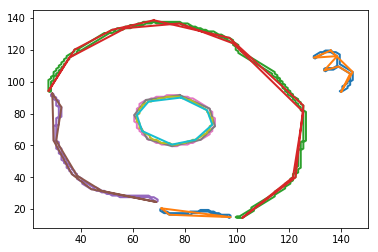

convexes: 3
concaves: 3
0 - score: 0.5


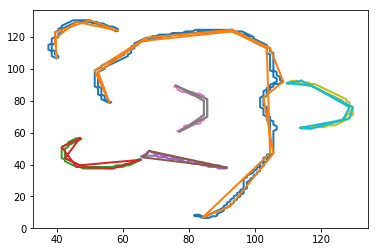

convexes: 1
concaves: 5
1 - score: 0.16666666666666663


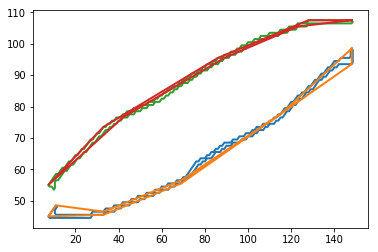

convexes: 0
concaves: 2
2 - score: 0.0


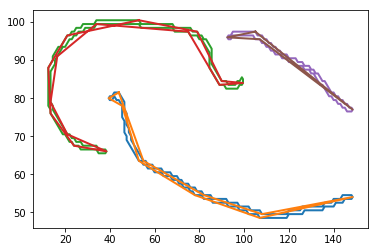

convexes: 0
concaves: 3
3 - score: 0.0


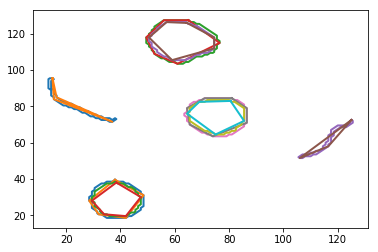

convexes: 7
concaves: 1
4 - score: 0.875


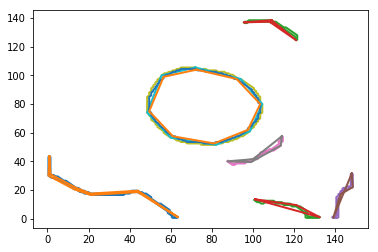

convexes: 3
concaves: 4
5 - score: 0.4285714285714286


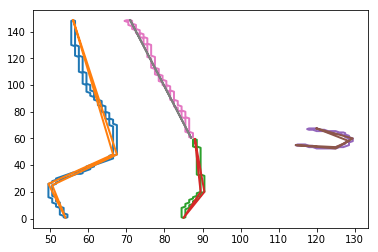

convexes: 0
concaves: 4
6 - score: 0.0


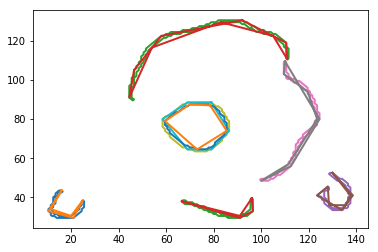

convexes: 2
concaves: 5
7 - score: 0.2857142857142857


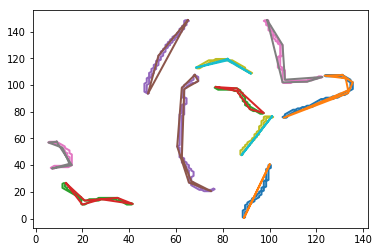

convexes: 1
concaves: 9
8 - score: 0.09999999999999998


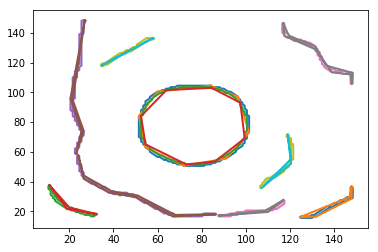

convexes: 2
concaves: 8
9 - score: 0.19999999999999996


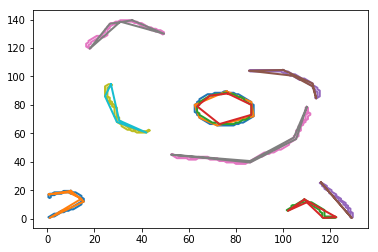

convexes: 2
concaves: 7
10 - score: 0.2222222222222222


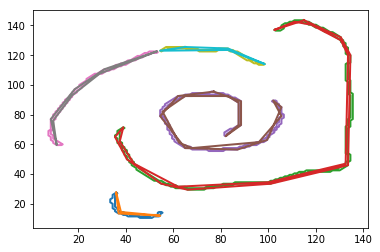

convexes: 0
concaves: 5
11 - score: 0.0


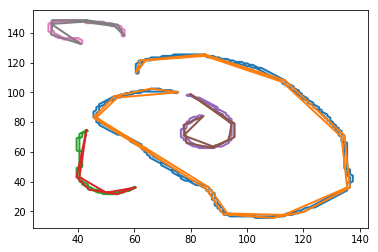

convexes: 0
concaves: 4
12 - score: 0.0


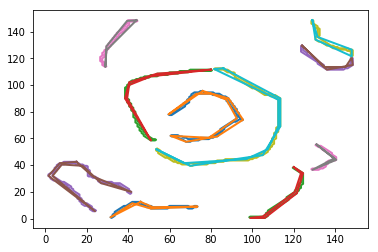

convexes: 0
concaves: 10
13 - score: 0.0


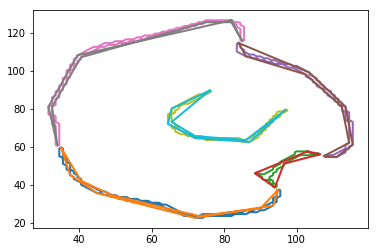

convexes: 0
concaves: 5
14 - score: 0.0


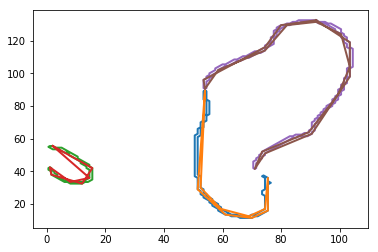

convexes: 0
concaves: 3
15 - score: 0.0


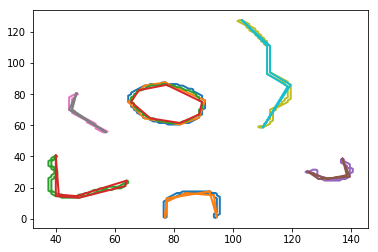

convexes: 2
concaves: 5
16 - score: 0.2857142857142857


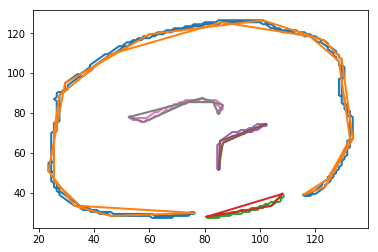

convexes: 1
concaves: 3
17 - score: 0.25


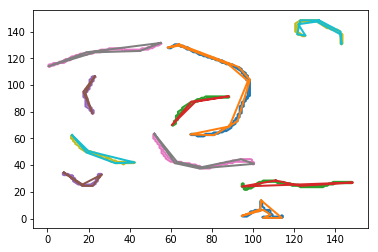

convexes: 0
concaves: 10
18 - score: 0.0


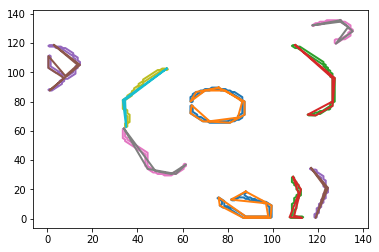

convexes: 0
concaves: 9
19 - score: 0.0


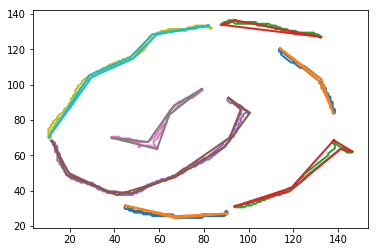

convexes: 1
concaves: 6
20 - score: 0.1428571428571429


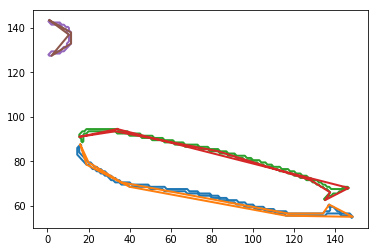

convexes: 0
concaves: 3
21 - score: 0.0


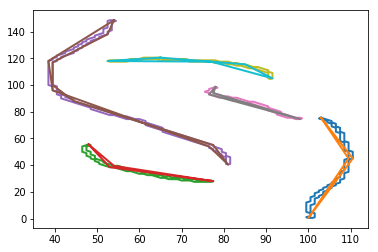

convexes: 0
concaves: 5
22 - score: 0.0


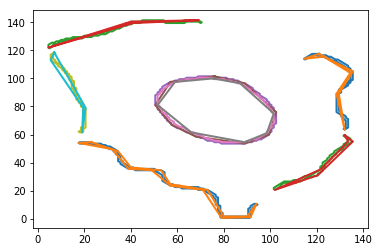

convexes: 2
concaves: 5
23 - score: 0.2857142857142857


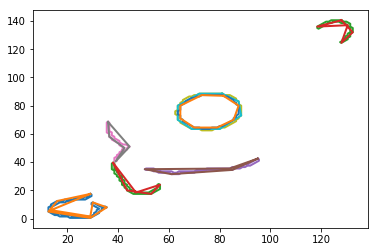

convexes: 2
concaves: 5
24 - score: 0.2857142857142857


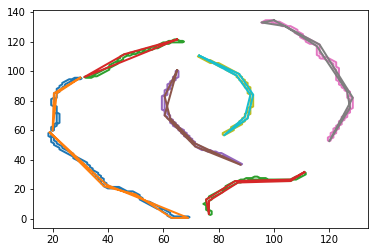

convexes: 1
concaves: 6
25 - score: 0.1428571428571429


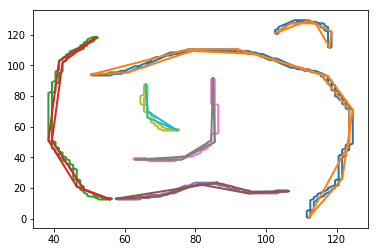

convexes: 0
concaves: 6
26 - score: 0.0


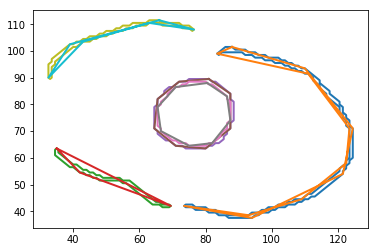

convexes: 3
concaves: 2
27 - score: 0.6


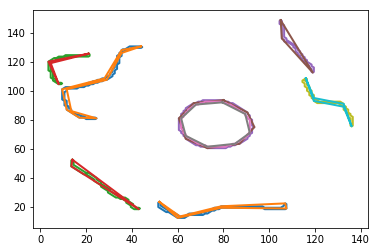

convexes: 4
concaves: 4
28 - score: 0.5


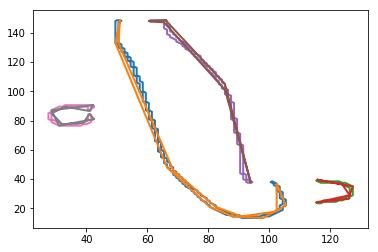

convexes: 0
concaves: 4
29 - score: 0.0


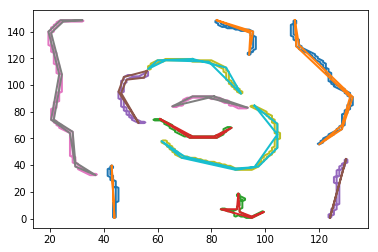

convexes: 0
concaves: 11
30 - score: 0.0


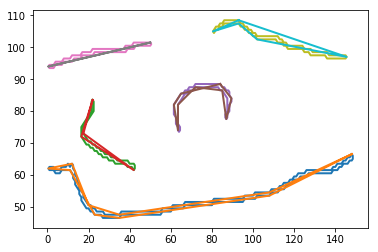

convexes: 0
concaves: 5
31 - score: 0.0


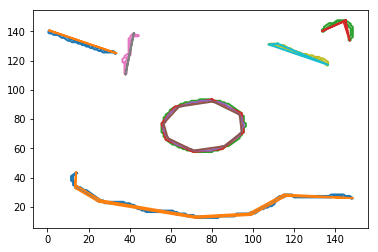

convexes: 3
concaves: 4
32 - score: 0.4285714285714286


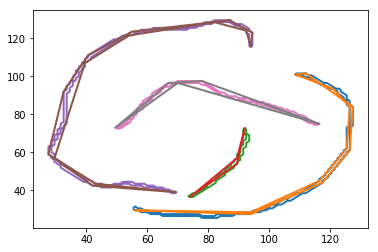

convexes: 0
concaves: 4
33 - score: 0.0


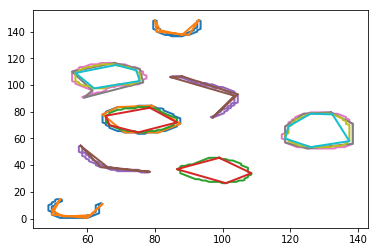

convexes: 6
concaves: 5
34 - score: 0.5454545454545454


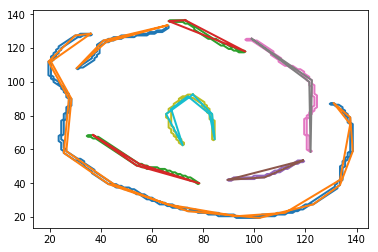

convexes: 2
concaves: 5
35 - score: 0.2857142857142857


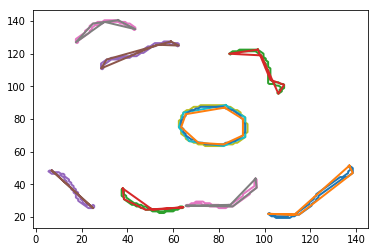

convexes: 2
concaves: 7
36 - score: 0.2222222222222222


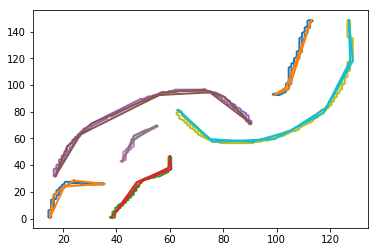

convexes: 0
concaves: 6
37 - score: 0.0


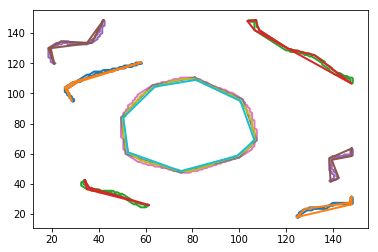

convexes: 2
concaves: 6
38 - score: 0.25


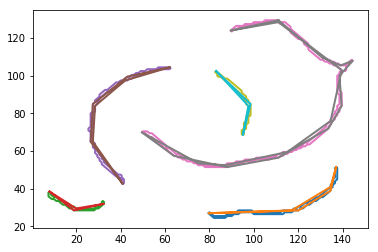

convexes: 0
concaves: 5
39 - score: 0.0


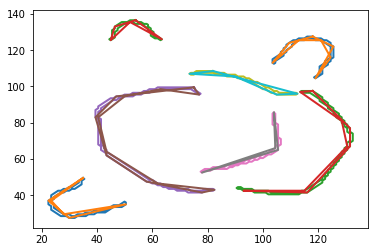

convexes: 0
concaves: 7
40 - score: 0.0


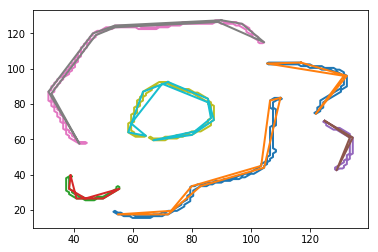

convexes: 0
concaves: 6
41 - score: 0.0


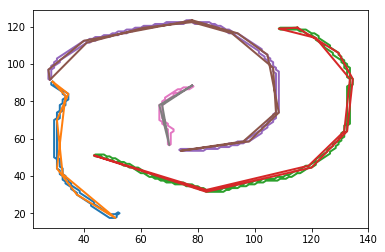

convexes: 0
concaves: 4
42 - score: 0.0


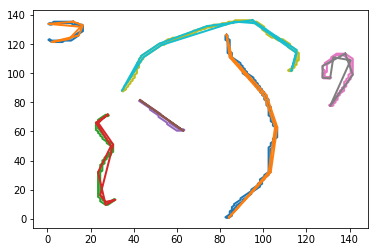

convexes: 0
concaves: 6
43 - score: 0.0


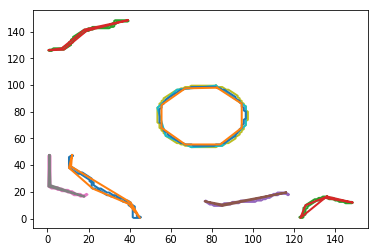

convexes: 2
concaves: 5
44 - score: 0.2857142857142857


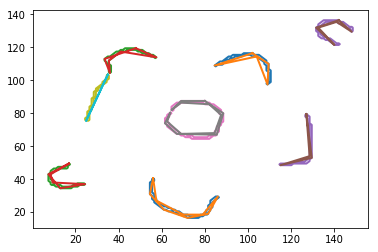

convexes: 0
concaves: 8
45 - score: 0.0


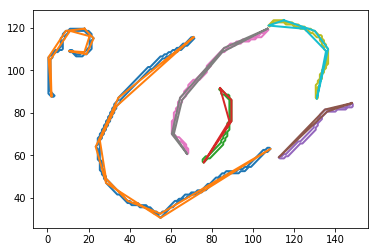

convexes: 0
concaves: 6
46 - score: 0.0


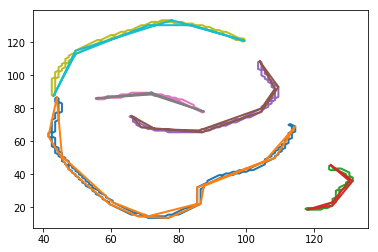

convexes: 0
concaves: 5
47 - score: 0.0


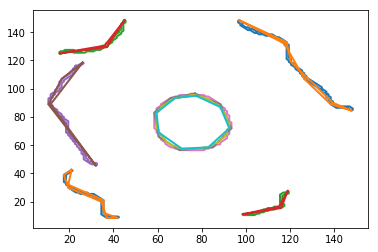

convexes: 2
concaves: 5
48 - score: 0.2857142857142857


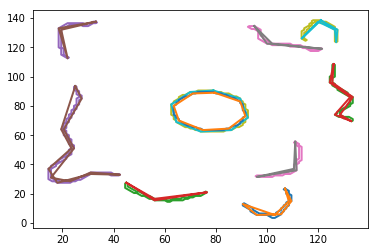

convexes: 2
concaves: 8
49 - score: 0.19999999999999996


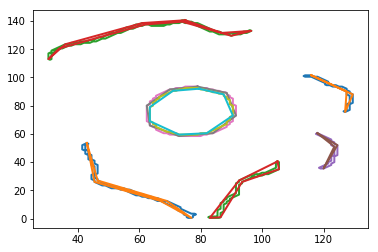

convexes: 2
concaves: 5
50 - score: 0.2857142857142857


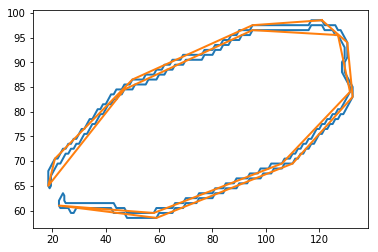

convexes: 0
concaves: 1
51 - score: 0.0


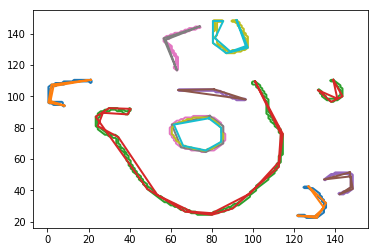

convexes: 3
concaves: 7
52 - score: 0.30000000000000004


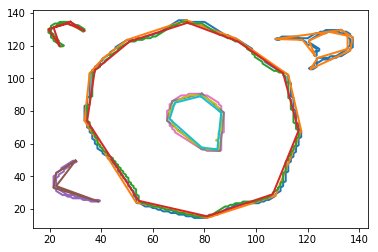

convexes: 4
concaves: 3
53 - score: 0.5714285714285714


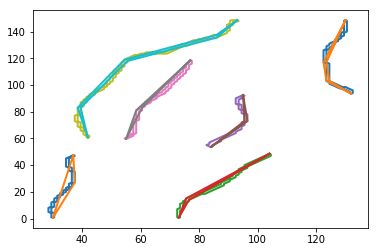

convexes: 1
concaves: 5
54 - score: 0.16666666666666663


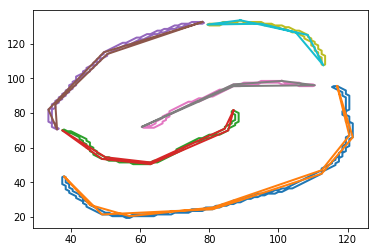

convexes: 0
concaves: 5
55 - score: 0.0


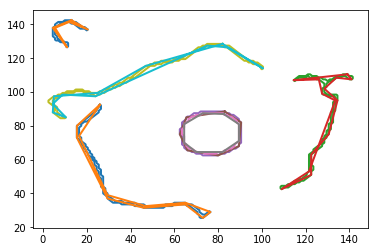

convexes: 2
concaves: 4
56 - score: 0.33333333333333337


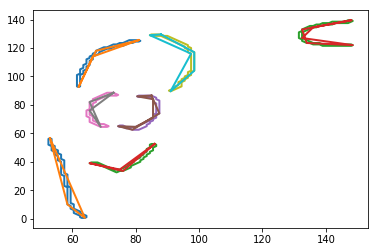

convexes: 1
concaves: 6
57 - score: 0.1428571428571429


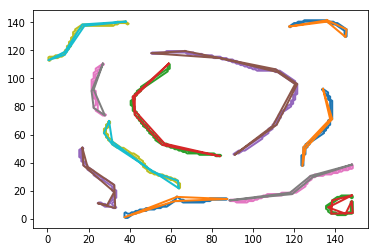

convexes: 0
concaves: 11
58 - score: 0.0


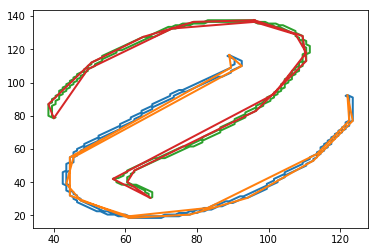

convexes: 0
concaves: 2
59 - score: 0.0


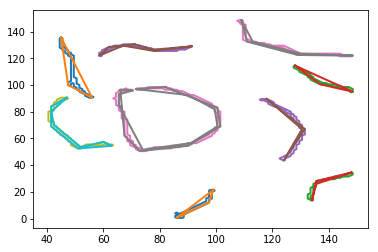

convexes: 3
concaves: 6
60 - score: 0.33333333333333337


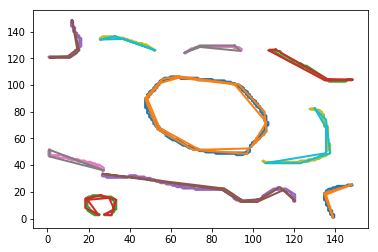

convexes: 1
concaves: 9
61 - score: 0.09999999999999998


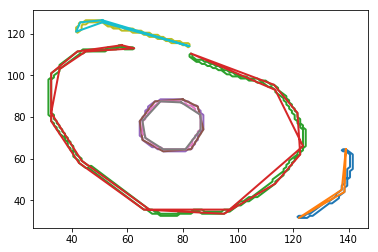

convexes: 2
concaves: 3
62 - score: 0.4


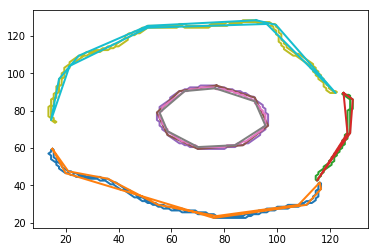

convexes: 2
concaves: 3
63 - score: 0.4


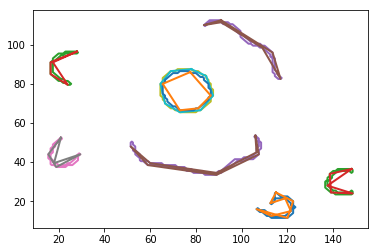

convexes: 2
concaves: 6
64 - score: 0.25


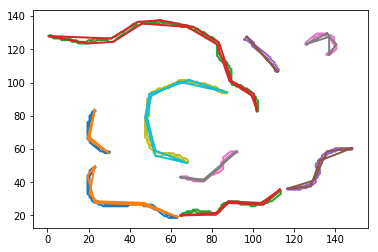

convexes: 0
concaves: 9
65 - score: 0.0


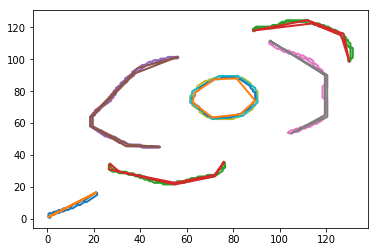

convexes: 2
concaves: 5
66 - score: 0.2857142857142857


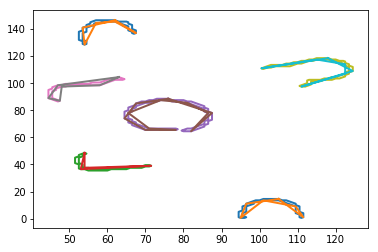

convexes: 0
concaves: 6
67 - score: 0.0


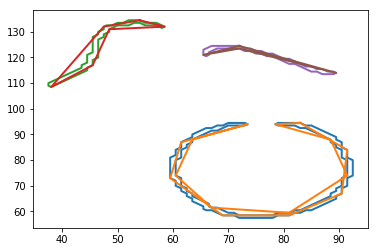

convexes: 0
concaves: 3
68 - score: 0.0


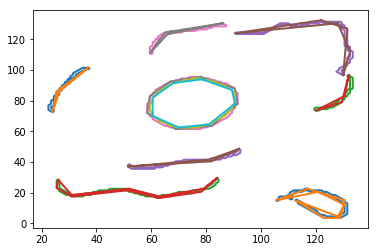

convexes: 2
concaves: 7
69 - score: 0.2222222222222222


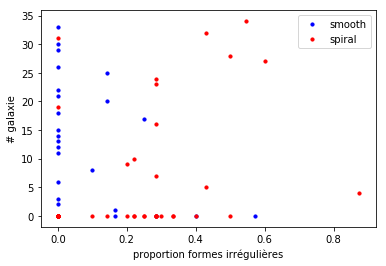

In [27]:
#PRIMITIVE CONTOUR-FORMES
#Vérifie la proportion de formes irrégulières (concaves) versus le nombre d'ellipse (convexes)
img_h = 424
img_w = 424
crop_value = 150

countBinary = 0
countSpiral = 0 
countSmooth = 0    


def cropImages(matrix, crop_val):
    len = matrix.shape[0]
    print("cropping",len,"images to",crop_val)
    X_train_crop = np.zeros((len, 3, crop_val, crop_val), dtype=np.uint8)
    for i in range(0,len):
        image = matrix[i].reshape(img_h, img_w, 3)
        image = image[424 // 2 - crop_val // 2 : 424 // 2 + crop_val // 2, 424 // 2 - crop_val // 2 : 424 // 2 + crop_val // 2] # garder 25 de chaque cote depuis le milieu, pour chaque axe
        image = image.reshape(3, crop_val, crop_val)
        X_train_crop[i] = image
    return X_train_crop

#x_cropped = cropImages(X, crop_value)

#source: https://stackoverflow.com/posts/43551628/revisions
def zCrossProduct(a,b,c):
    return (a[0]-b[0])*(b[1]-c[1])-(a[1]-b[1])*(b[0]-c[0])

#adapté de: https://stackoverflow.com/posts/43551628/revisions
def isVConvex(vertices):
    if len(vertices)<4:
        return False #pour nos besoins, on rejette les droites et les triangles
    signs= [zCrossProduct(a,b,c)>0 for a,b,c in zip(vertices[2:],vertices[1:],vertices)]
    return all(signs) or not any(signs)


def processImage(img):
    gaussfilterSigma = 0.9
    cannySigma = 6.0
    contourLevel=0.5
    contourMinimumPoints = 75
    
    lowerFlattenThreshold = 20
    lowerFlattenValue = 0
    UppperFlattenThreshold = 135
    UpperFlattenValue = 150
    
    #image originale
    #f = plt.figure()
    #ax1 = f.add_subplot(221)
    #ax1.title.set_text("original")
    #plt.imshow(img)
    
    #application du filtre gaussien pour réduire les artefacts
    gaussfiltered = filters.gaussian(img, sigma=gaussfilterSigma)
    #ax2= f.add_subplot(222)
    #ax2.title.set_text("gauss filtered")
    #plt.imshow(gaussfiltered)
    
    #enlèvement du bruit sur le fond noir
    im = np.where(np.logical_and(0<=gaussfiltered, gaussfiltered<=lowerFlattenThreshold), lowerFlattenValue, gaussfiltered)
    im = np.where(np.logical_and(UppperFlattenThreshold<=im, im<=255), UpperFlattenValue, im)
    #ax3 = f.add_subplot(223)
    #ax3.title.set_text("extreme values flattened")
    #plt.imshow(im)
    
    #detection des rebords
    edges = feature.canny(im, sigma=cannySigma) #
    #edges = feature.canny(im, sigma=4.0, low_threshold=0.55, high_threshold=0.8)
    #ax4= f.add_subplot(224)
    #ax4.title.set_text("edges highlighted")
    #plt.imshow(edges)
        
    contours = find_contours(edges, level=contourLevel, fully_connected="high")
 
    contours = [c for c in contours if len(c) >= contourMinimumPoints] #éliminer les artéfacts minuscules
    nbConvex = 0
    nbNonConvex = 0
    
    #fig, ax = plt.subplots()
    #ax.imshow(im, interpolation='nearest', cmap=plt.cm.gray)
    for n, cnt in enumerate(contours):
        plt.plot(cnt[:, 1], cnt[:, 0], linewidth=2)
    
    #for cnt in contours:
        #print(len(cnt), "contours")
        coords = approximate_polygon(cnt, tolerance=3)
        #plt.plot(cnt[:, 1], cnt[:, 0], linewidth=1)
        #plt.show()
        plt.plot(coords[:,1], coords[:,0], linewidth=2)
        if (isVConvex(coords)): #verifie si est convexe
            nbConvex +=1
        else:
            nbNonConvex +=1

        #plt.show()
        #print("corners",coords.shape[0])
        #plt.plot(corners[:,1], corners[:,0],linewidth=1)
    plt.show()
    print("convexes:",nbConvex)
    print("concaves:",nbNonConvex)
    score = 1-(nbNonConvex/(nbConvex + nbNonConvex))
    return score

#mise en tons de gris de plusieurs images
def grayscaleImages(matrix):
    countBinary = 0
    countSpiral = 0 
    countSmooth = 0    
    len = matrix.shape[0]
    print("len", len)
    x_grayed = np.zeros((len, matrix[0].shape[1], matrix[0].shape[2]),dtype=np.uint8)
    for i in range(0,len):
        #print("image", i+1)
        image = matrix[i].reshape( matrix[i].shape[1], matrix[i].shape[2], 3)
        imageGray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
        score = processImage(imageGray)
        print(i,"- score:", score)
        if Y_train[countBinary][0] == "smooth" :
            X_train_color_plot[countSmooth][0][3] = score
            countSmooth+=1
        else :
            X_train_color_plot[countSpiral][1][3] = score
            countSpiral+=1
        countBinary+=1
        
        
        imageGray = imageGray.reshape(1,matrix[i].shape[1], matrix[i].shape[2])
        x_grayed[i] = imageGray
        #plt.imshow(imageGray)
        #plt.show()
    return x_grayed
    

x_grayed = grayscaleImages(X_train_crop)

# afficher graphe primitives
cm = plt.cm.RdBu

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train_color_plot[:,1,3], X_train_color_plot[:,1,4] , s=10, c='b', label='smooth')
ax1.scatter(X_train_color_plot[:,0,3], X_train_color_plot[:,0,4], s=10, c='r', label='spiral')
plt.legend(loc='upper right');
plt.xlabel('proportion formes irrégulières')
plt.ylabel('# galaxie')
plt.show()

In [ ]:
# to visualize the tree you must install this library
# conda install python-graphviz OR pip install graphviz
import graphviz
from sklearn import tree

In [32]:
X_train  = np.zeros((CONST_NB_TRAIN,3))
Y_train =  np.zeros((CONST_NB_TRAIN,1))

for i in range(0,34) :
    X_train[i] = X_train_color_plot[i,0,0:3]
    Y_train[i][0] = 0
for i in range(0,34) :
    X_train[i+35] = X_train_color_plot[i,1,0:3]
    Y_train[i+35][0] = 1  

In [33]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = None)
model = model.fit(X_train, Y_train)

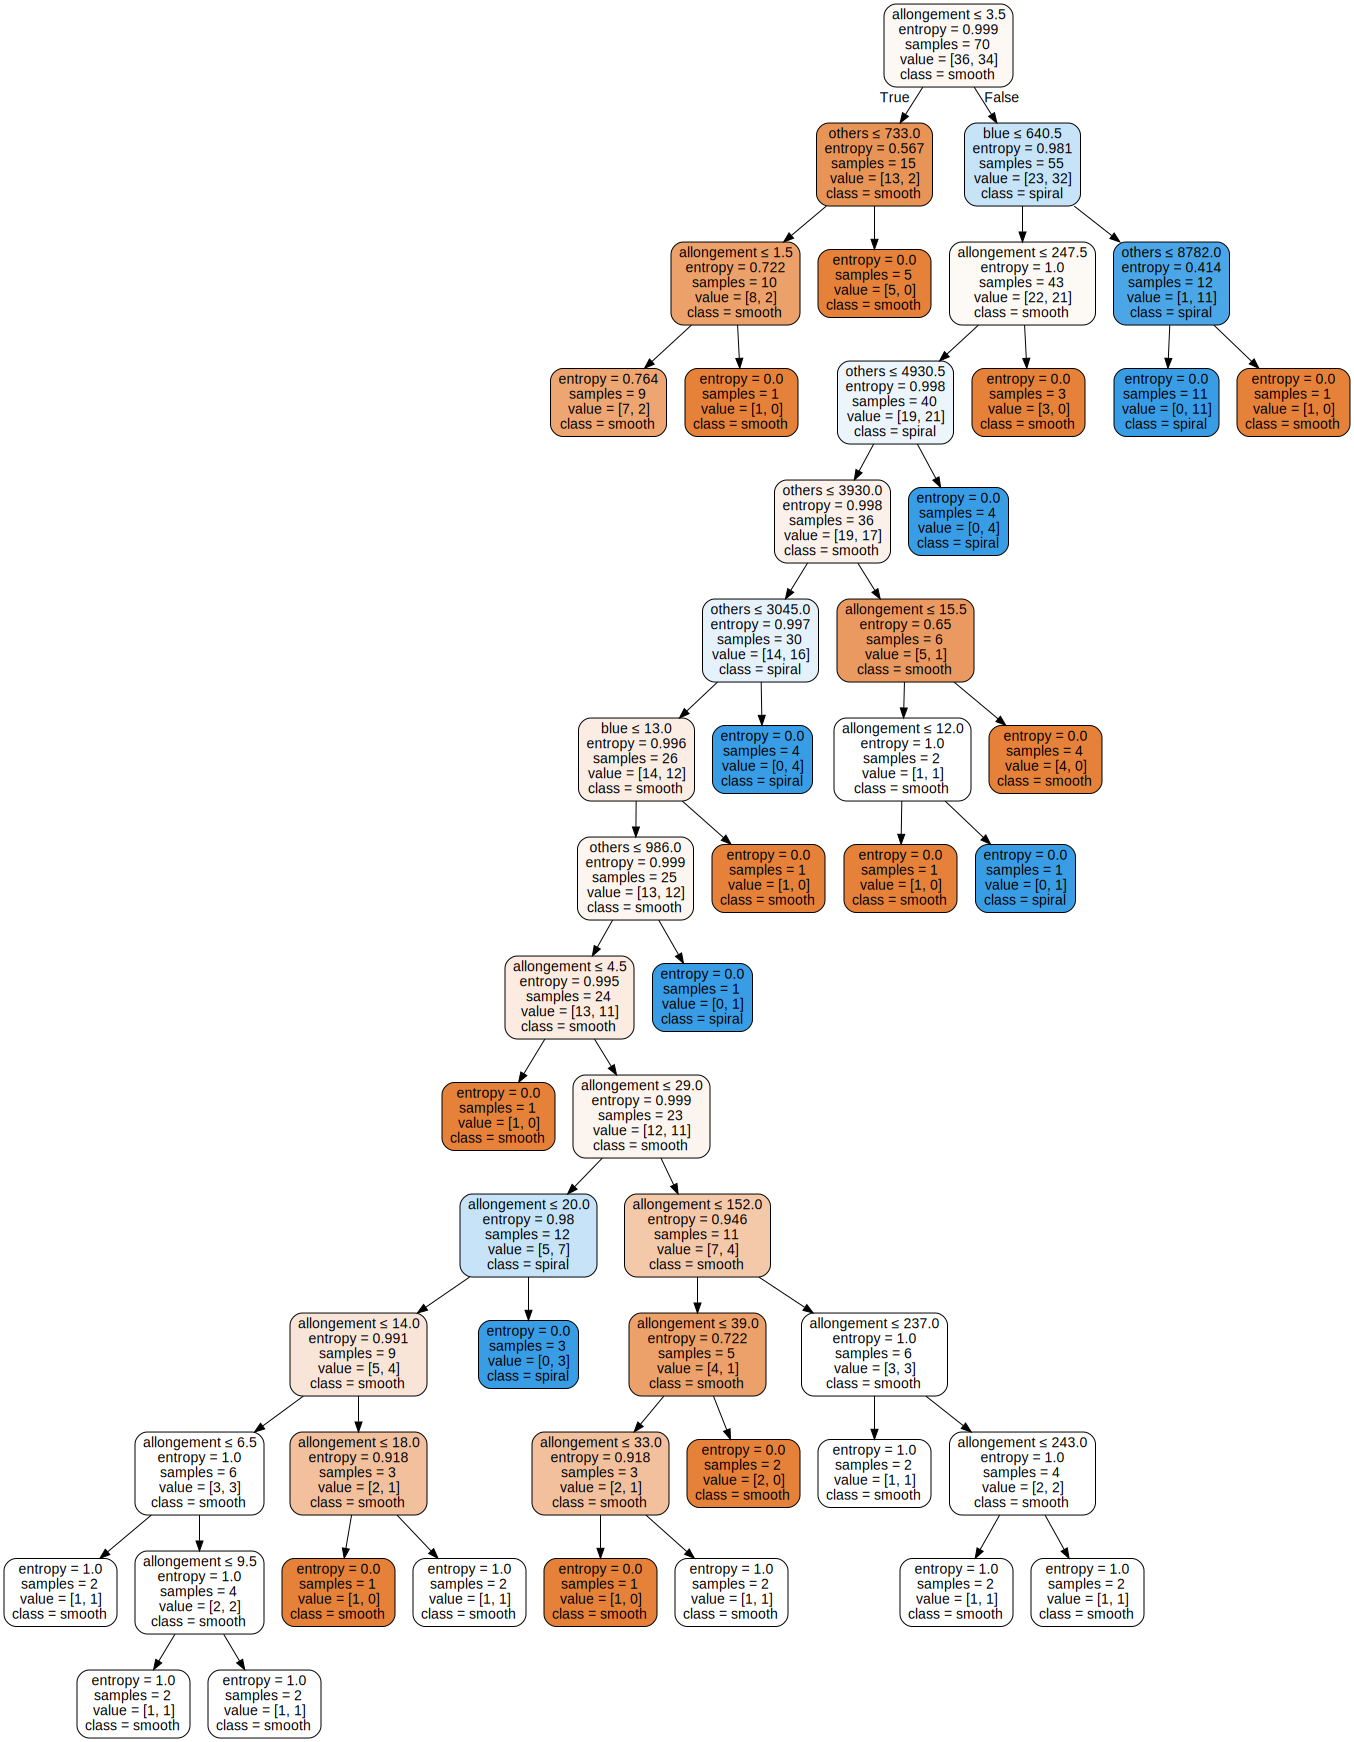

In [34]:
# Visualize the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['blue', 'others', 'allongement'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_Data", view=True) 
graph 

In [ ]:
Y_train_pred = model.predict(X_train)

In [ ]:
# predict the probability of each class
# train dataset

Y_train_pred_prob = model.predict_proba(X_train)


In [ ]:
# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
acc_galaxy_train = accuracy_score(Y_train, Y_train_pred )
print("Correct classification rate for test dataset = "+str(acc_galaxy_train*100)+"%")

In [ ]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 2)
model = model.fit(X_train, Y_train)

In [ ]:
# Visualize the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['blue', 'others', 'allongement'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_Data", view=True) 
graph 

In [ ]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 3)
model = model.fit(X_train, Y_train)

# Visualize the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['blue', 'others', 'allongement'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_Data", view=True) 
graph 

In [ ]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
model = model.fit(X_train, Y_train)

# Visualize the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['blue', 'others', 'allongement'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_Data", view=True) 
graph 

In [ ]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 5)
model = model.fit(X_train, Y_train)

# Visualize the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['blue', 'others', 'allongement'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_Data", view=True) 
graph 

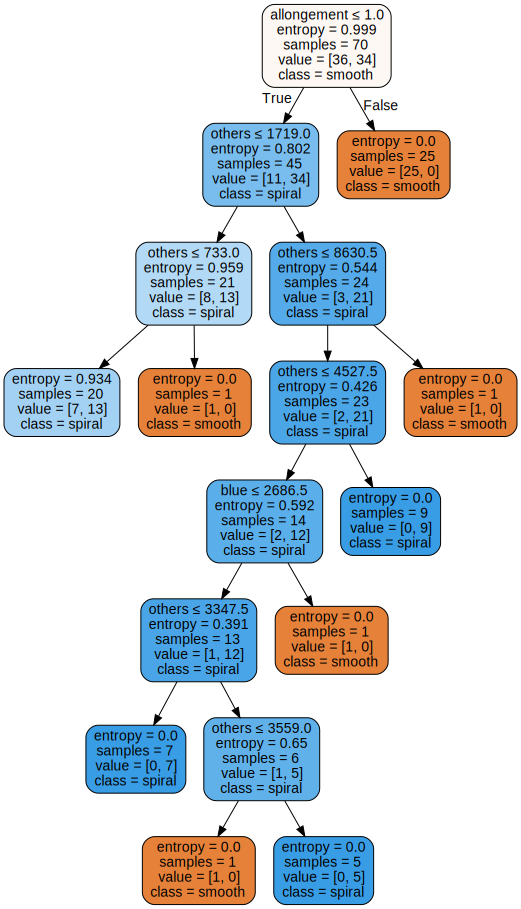

In [30]:
# Train the Decision Tree with the training set
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 10)
model = model.fit(X_train, Y_train)

# Visualize the tree

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names = ['blue', 'others', 'allongement'],  
                         class_names = ['smooth', 'spiral'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("Galaxy_Data", view=True) 
graph 

### Question 1

**Avec les liens fournis en l’annexe de cet énoncé et avec vos trouvailles faites sur Internet par le
biais de vos recherches personnelles, faites, à titre d’introduction, une revue de la littérature. Celle-ci
doit faire état des recherches ayant été faites en la matière et des possibles pistes que vous
pourriez suivre durant ce laboratoire pour effectuer l’extraction de primitives sur les images de
galaxies.**

Plusieurs différences prennent place entre les deux types de galaxies (smooth et spirale).  
  
Les prochaines définitions viennent de la source : http://www.astro.cornell.edu/academics/courses/astro201/galaxies/types.htm  
Nous trouvions que cette source décrivait bien les différents type de galaxie:  
  
'Les galaxies elliptiques (smooth) ont la forme d'une sphère ou d'une sphère allongée. Dans le ciel, où nous ne pouvons voir que deux de leurs trois dimensions, ces galaxies ressemblent à des disques elliptiques ou ovales. La lumière est douce, la luminosité de la surface diminuant au fur et à mesure que l'on s'éloigne du centre. Les galaxies elliptiques reçoivent une classification qui correspond à leur allongement à partir d'un cercle parfait, autrement dit leur ellipticité. Plus le nombre est grand, plus la galaxie est elliptique. Ainsi, par exemple une galaxie de classification de E0 apparaît parfaitement circulaire, alors qu'une classification de E7 est très aplatie. L'échelle elliptique varie de E0 à E7. Les galaxies elliptiques n'ont pas d'axe de rotation particulier.'  
  
'Les galaxies spirales ont trois composantes principales: un renflement, un disque et un halo (voir à droite). Le renflement est une structure sphérique trouvée dans le centre de la galaxie. Cette fonctionnalité contient principalement des étoiles plus anciennes. Le disque est constitué de poussière, de gaz et d'étoiles plus jeunes. Le disque forme des structures de bras. Notre Soleil est situé dans un bras de notre galaxie, la Voie Lactée. Le halo d'une galaxie est une structure sphérique lâche située autour du renflement et une partie du disque. Le halo contient de vieilles grappes d'étoiles, appelées amas globulaires.'  
  
    
Mise à part ces dernières définitions, nous pouvons noter que les galaxies spirales contiennent majoritairement des étoiles plus vieilles, et donc on plus de chances d'avoir des géantes bleues. On note alors souvent une différence dans les couleurs entre les deux types de galaxie.

### Question 2 

**Expliquer le choix des primitives. Quelle démarche avez-vous suivie afin d’effectuer votre choix
de primitives? Sur quelles sources vous êtes-vous basées afin d’établir votre choix de primitives?**

Avec les informations précédentes, nous avons établit trois primitives de bases :  
  
1. La présence de lumière bleu risque d'être plus présente en plus grande présence dans la plupart des galaxie spirale.  
  
2. Certaines galaxies spirales ont tendances à être allongées et n'adoptent pas une forme circulaire.

3. Les galaxies de types spirales peuvent aussi avoir des irrégularité dans leur forme.

### Question 3 

**À l’aide de graphiques générés par votre script, expliquez l’efficacité de deux primitives qui
permettent de bien distinguer les classes du problème.**

Grâce à nos primitives, et de graphiques générés avec les données récoltés par ceux-ci, on peut voir une bonne dispersion des différents points de certains types de galaxies. Par exemple, si nous prenons les graphiques de la primitive du score de l'allongement de la forme de la galaxie ainsi que la primitive de l'irrégularité de la forme, nous pouvons voir que les galaxies smooth et spiral tendent à ce séparer les unes aux autres. Par contre, elle ne semble pas complétement parfaite, ce qui est très logique, puisqu'il existe des exeptions dans les types de galaxies, et que nous n'avons pas toujours les photos parfaite à évaluer.

### Question 4 

**À la suite de votre implémentation de l’arbre de décision, expliquer pour quelles raisons votre arbre
de décision donne un tel score de précision. Qu’a fait la variable max_depth sur les performances
de classification? Comment l’arbre de décision réagit-il au bruit?**

Suite à notre implémentation de l'arbre de décision, nous avons obtenus des résultats intéressants.  

Le changement de la variable max_depth change tout de même drastiquement la taille de l'arbre, mais pas nécessairement les performances de classification. Quand la variable est trop basse, on constate une sous qualification (underfit) de l'arbre de décision, et l'inverse est aussi vrai pour la sur qualification (overfit). Il a donc fallu trouver un juste milieu pour que la taille de l'arbre présente une bonne clasification (élagage des noeuds). Nous constatons aussi que l'arb

### Question 5 

**Quelle autre primitive aurait également pu être ajoutée afin d’améliorer le pouvoir discriminant ou
la performance de régression des probabilités?**

Une primitive qui aurait pu être intéressante pour le projet aurait pu être l'évaluation de la luminosité des galaxies. En effet, les galaxies de type smooths sont souvent plus lumineuses uniformément dans leur ensemble. Ceci aurait donc pu augmenter le pouvoir discriminant des primitives pour permettre une meilleure séparation entre les types. 

### Question 6 

**Écrivez une conclusion qui résume le contenu de votre rapport. Dites, en résumé, la manière dont
vous avez résolu le problème, quelles ont été vos primitives et les résultats que vous avez obtenus,
et glissez un mot sur des améliorations possibles. Dites également, le cas échéant, ce qui a moins
bien été durant la réalisation de ce laboratoire.**

Nous avons eu assez de difficulté lors de notre tentative d'établir une primitive suffisament discriminante basée sur  la forme concave des galaxies spirales par rapport à la forme plus convexe des galaxies smooth. La tâche a été ardue puisqu'il fallait utiliser plusieurs prétraitements successifs pour éliminer suffisament d'artéfacts et de bruit pour de la détection de contour requise pour l'analyse de la forme. Malgré cela, les résultats ont été moins concluants que prévus en raison de la présence de plusieurs galaxies difficiles à départager sur certaines images, ainsi que certaines galaxies dont le contour était interrompu par la bordure de l'image, ce qui compliquait la tâche d'identification par cette approche.